In [ ]:
import polars as pl 
import sys
from pathlib import Path
import importlib
import matplotlib.pyplot as plt
import numpy as np 
from collections import Counter

# Set the font family to Arial
# https://g.co/gemini/share/3898a74b2d77
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial'] # Add Arial to the sans-serif list

plt.rcParams.update({
    'font.size': 20,
})

REFERENCE_GENOME = "hg38"
TILE_SIZE = 1000
METH_READ_PHASED_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs')
SAMPLE = 'NA12878' # '200081' 
BED_METH = f"{METH_READ_PHASED_DIR}/{SAMPLE}.dna-methylation.founder-phased.all_cpgs.sorted.bed.gz"

REPO_DIR = Path("/scratch/ucgd/lustre-labs/quinlan/u6018199/tapestry")
sys.path.append(str(REPO_DIR / "src" / "util"))
sys.path.append(f"{REPO_DIR}/src") 

DELTA_METH_THRESHOLD = 0.9

pl.Config.set_tbl_rows(10) 

polars.config.Config

## Tile the genome 

In [2]:
import tile
importlib.reload(tile)
from tile import get_tiles 

DF_TILES = get_tiles(REFERENCE_GENOME, TILE_SIZE)
DF_TILES

chrom,start,end
str,i64,i64
"""chr1""",0,1000
"""chr1""",1000,2000
"""chr1""",2000,3000
"""chr1""",3000,4000
"""chr1""",4000,5000
…,…,…
"""chrM""",11000,12000
"""chrM""",12000,13000
"""chrM""",13000,14000


## [Single Sample] Fetch phased and unphased DNA methylation at all CpG sites in the reference and sample genome

In [3]:
import read_data
importlib.reload(read_data)
from read_data import read_tapestry

DF_METH = read_tapestry(BED_METH)
DF_METH.sample(10)

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr20""",32018905,32018907,65,0.231,0.03,31739743,32503371,1.0,345,35,30,"""I""","""K""",0.286,0.167,0.028,0.033,false,false,""".""",false
"""chr7""",68869863,68869865,100,0.58,0.638,68102227,70581212,1.0,2421,41,59,"""I""","""K""",0.585,0.576,0.663,0.6,false,false,""".""",false
"""chr9""",77367795,77367797,112,0.83,0.952,null,null,null,null,null,null,null,null,null,null,null,null,false,false,""".""",false
"""chr2""",49682246,49682248,143,0.692,0.804,49375371,51642229,1.0,2716,75,68,"""I""","""K""",0.733,0.647,0.834,0.772,false,false,""".""",false
"""chr19""",53708820,53708822,66,0.788,0.939,53599268,54202986,1.0,646,32,34,"""I""","""K""",0.813,0.765,0.947,0.929,false,false,""".""",false
"""chr6""",144330695,144330697,101,0.762,0.951,144301536,144700348,1.0,223,48,53,"""I""","""K""",0.771,0.755,0.949,0.946,false,false,""".""",false
"""chr2""",112630533,112630535,71,0.268,0.215,112630322,113704619,1.0,1305,42,29,"""I""","""K""",0.214,0.345,0.11,0.383,false,false,""".""",false
"""chr7""",6058202,6058204,60,0.85,0.946,5849637,6187535,1.0,304,27,33,"""I""","""K""",0.889,0.818,0.952,0.918,false,false,""".""",false
"""chr2""",99759576,99759578,112,0.786,0.944,99532741,99947597,1.0,223,57,54,"""I""","""K""",0.754,0.815,0.943,0.937,false,false,""".""",false


## [Single Sample] Filter out allele-specific CpG sites as these can masqeurade as imprinted loci 

In [4]:
# Notice the values of "0.0" for count-based methylation on one of the haplotypes in this filter: 
DF_METH.filter(pl.col('cpg_is_allele_specific')).sample(10)

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr14""",98987724,98987726,99,0.485,0.524,98923154,99080763,1.0,142,48,51,"""I""","""K""",0.0,0.941,0.052,0.961,false,true,"""het""",true
"""chr18""",17942347,17942349,98,0.337,0.567,null,null,null,null,null,null,null,null,null,null,null,null,false,true,"""het""",true
"""chr20""",14892969,14892971,113,0.363,0.483,14767647,14969361,1.0,186,61,52,"""I""","""K""",0.672,0.0,0.884,0.048,false,true,"""het""",true
"""chr10""",92337373,92337375,103,0.553,0.536,91580310,92915602,1.0,1109,58,45,"""I""","""K""",0.983,0.0,0.959,0.054,false,true,"""het""",true
"""chr15""",78066494,78066496,80,0.338,0.391,77652227,78315987,1.0,1090,39,41,"""I""","""K""",0.0,0.659,0.045,0.819,false,true,"""het""",true
"""chr13""",17584148,17584150,251,0.849,0.928,null,null,null,null,null,null,null,null,null,null,null,null,false,true,"""het""",true
"""chr11""",18681194,18681196,72,0.431,0.527,18467883,19115609,1.0,553,41,31,"""I""","""K""",0.756,0.0,0.869,0.057,false,true,"""het""",true
"""chr7""",440430,440432,62,0.339,0.41,75637,560546,1.0,503,28,34,"""I""","""K""",0.0,0.618,0.058,0.777,false,true,"""het""",true
"""chr20""",552159,552161,95,0.421,0.49,391136,817544,1.0,392,52,43,"""I""","""K""",0.769,0.0,0.886,0.05,false,true,"""het""",true


In [5]:
DF_METH_FREE_FROM_ALLELE_SPECIFIC_CPGS = DF_METH.filter(~pl.col('cpg_is_allele_specific'))

## [Single Sample] Compute difference in methylation between haplotypes in tiles

In [6]:
import methylation
importlib.reload(methylation)
from methylation import compute_methylation

DF_TILES_WITH_METH = compute_methylation(DF_TILES, DF_METH_FREE_FROM_ALLELE_SPECIFIC_CPGS)
DF_TILES_WITH_METH.sample(10)

chrom,start,end,num_cpgs,founder_pat,founder_mat,count_based_meth,num_cpgs_with_non_null_count_based_meth,model_based_meth,count_based_meth_pat,num_cpgs_with_non_null_count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,num_cpgs_with_non_null_count_based_meth_mat,model_based_meth_mat
str,i64,i64,u32,list[str],list[str],f64,u32,f64,f64,u32,f64,f64,u32,f64
"""chr15""",82013000,82014000,15,"[""I""]","[""K""]",0.791467,15,0.877667,0.812667,15,0.880533,0.769067,15,0.865467
"""chr7""",145221000,145222000,15,[null],[null],0.7704,15,0.836667,null,0,null,null,0,null
"""chrX""",67148000,67149000,4,"[""I""]","[""K""]",0.58125,4,0.63425,0.568,4,0.64075,0.59075,4,0.622
"""chr12""",95456000,95457000,13,"[""I""]","[""K""]",0.768308,13,0.897538,0.769462,13,0.888,0.767385,13,0.890923
"""chr3""",82206000,82207000,3,"[""I""]","[""K""]",0.394667,3,0.369667,0.47,3,0.494333,0.333,3,0.279333
"""chr4""",43584000,43585000,9,[null],[null],0.800444,9,0.924778,null,0,null,null,0,null
"""chrY""",6868000,6869000,6,[null],[null],null,0,null,null,0,null,null,0,null
"""chr3""",115329000,115330000,3,[null],[null],0.625333,3,0.734333,null,0,null,null,0,null
"""chr5""",104643000,104644000,3,"[null, ""I""]","[null, ""K""]",0.804,2,0.919,0.8275,2,0.9155,0.785,2,0.921


Text(0, 0.5, 'Number of tiles')

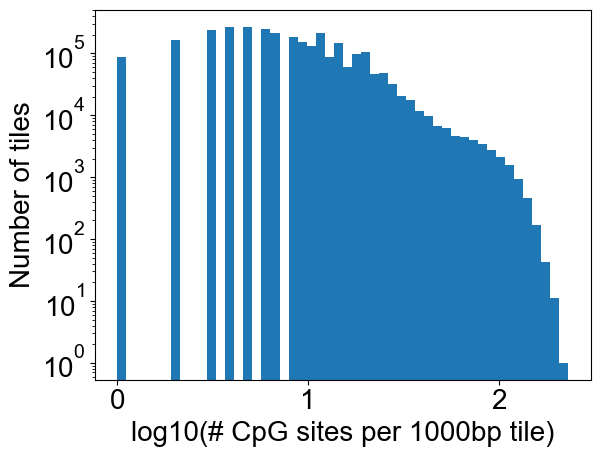

In [7]:
plt.hist(
    np.log10(DF_TILES_WITH_METH["num_cpgs"]), 
    bins=50, # type: ignore
    alpha=None, 
    label=None,
    color=None
)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(f'log10(# CpG sites per {TILE_SIZE}bp tile)')
plt.ylabel('Number of tiles')

In [8]:
import imprinting
importlib.reload(imprinting)
from imprinting import compute_delta_methylation

DF_TILES_WITH_DELTA_METH = compute_delta_methylation(DF_TILES_WITH_METH)
DF_TILES_WITH_DELTA_METH.sample(10)

chrom,start,end,num_cpgs,founder_pat,founder_mat,num_cpgs_with_non_null_count_based_meth,count_based_meth_pat,num_cpgs_with_non_null_count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,num_cpgs_with_non_null_count_based_meth_mat,model_based_meth_mat,delta_of_count_based_meth,delta_of_model_based_meth
str,i64,i64,u32,list[str],list[str],u32,f64,u32,f64,f64,u32,f64,f64,f64
"""chr1""",179144000,179145000,13,"[""I""]","[""K""]",13,0.865308,13,0.930846,0.870846,13,0.941615,-0.005538,-0.010769
"""chrX""",60471000,60472000,23,[null],[null],22,null,0,null,null,0,null,null,null
"""chrX""",72189000,72190000,11,"[""I""]","[""K""]",11,0.802182,11,0.924909,0.740273,11,0.875,0.061909,0.049909
"""chr12""",2794000,2795000,78,"[""I""]","[""K""]",78,0.208436,78,0.105256,0.212756,78,0.134769,-0.004321,-0.029513
"""chr1""",104729000,104730000,3,"[""I""]","[""K""]",3,0.753,3,0.862333,0.684667,3,0.819333,0.068333,0.043
"""chr12""",40330000,40331000,1,"[""I""]","[""K""]",1,0.744,1,0.886,0.795,1,0.869,-0.051,0.017
"""chr1""",248849000,248850000,7,"[""I""]","[""K""]",7,0.743571,7,0.912857,0.810714,7,0.934857,-0.067143,-0.022
"""chr1""",165664000,165665000,5,"[""I""]","[""K""]",5,0.8178,5,0.9216,0.809,5,0.942,0.0088,-0.0204
"""chr4""",170414000,170415000,4,"[""I""]","[""K""]",4,0.626,4,0.7995,0.6385,4,0.74225,-0.0125,0.05725


## [Single Sample] False imprinting calls due to there being just one CpG with non-null methylation levels on each haplotype

In [9]:
# An example of a tile that would be called as imprinted based solely on delta_of_count_based_meth, 
# but that can be recognized as untrustworthy based upon the low value of 
# num_cpgs_with_non_null_count_based_meth_pat and num_cpgs_with_non_null_count_based_meth_mat . 
# In this case, the zero value of methylation on the paternal haplotype is false: 
# the CpG site was destroyed on that haplotype by an SNV that wasn't called in the vcf. 
DF_TILES_WITH_DELTA_METH.filter(
    (pl.col('chrom') == 'chr1') & 
    (pl.col('start') == 146170000)
)

chrom,start,end,num_cpgs,founder_pat,founder_mat,num_cpgs_with_non_null_count_based_meth,count_based_meth_pat,num_cpgs_with_non_null_count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,num_cpgs_with_non_null_count_based_meth_mat,model_based_meth_mat,delta_of_count_based_meth,delta_of_model_based_meth
str,i64,i64,u32,list[str],list[str],u32,f64,u32,f64,f64,u32,f64,f64,f64
"""chr1""",146170000,146171000,6,"[null, ""I""]","[null, ""K""]",6,0.0,1,0.059,0.948,1,0.952,-0.948,-0.893


## [All Samples] Compute difference of haplotype-specific methylations for all samples 

In [10]:
# [TESTING] 2 mins to run for 2 samples
cmd = f"python analysis/imprinting.py --reference_genome {REFERENCE_GENOME} --tile_size {TILE_SIZE} --meth_read_phased_dir {METH_READ_PHASED_DIR} --output_bed analysis/delta_meth_all_samples.bed"
testing_cmd = f"PYTHONPATH=src/util {cmd} --testing"
testing_cmd

'PYTHONPATH=src/util python analysis/imprinting.py --reference_genome hg38 --tile_size 1000 --meth_read_phased_dir /scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs --output_bed analysis/delta_meth_all_samples.bed --testing'

In [11]:
# [Production] 25 mins to run for all samples
production_cmd = f"PYTHONPATH=src/util nohup {cmd} > analysis/delta_meth_all_samples.log 2>&1 &" 
production_cmd

'PYTHONPATH=src/util nohup python analysis/imprinting.py --reference_genome hg38 --tile_size 1000 --meth_read_phased_dir /scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs --output_bed analysis/delta_meth_all_samples.bed > analysis/delta_meth_all_samples.log 2>&1 &'

In [48]:
from read_data import read_dataframe_from_bed

def read_all_samples(bed): 
    df = read_dataframe_from_bed(bed)
    return df

DF_DELTA_METH_ALL_SAMPLES = read_all_samples('delta_meth_all_samples.bed')
print(len(DF_DELTA_METH_ALL_SAMPLES))
DF_DELTA_METH_ALL_SAMPLES.sample(10)

2903221


chrom,start,end,NA12877_num_cpgs,NA12877_num_valid_cpgs,NA12877_num_valid_cpgs_pat,NA12877_num_valid_cpgs_mat,NA12877_count,NA12877_model,NA12878_num_cpgs,NA12878_num_valid_cpgs,NA12878_num_valid_cpgs_pat,NA12878_num_valid_cpgs_mat,NA12878_count,NA12878_model,NA12887_num_cpgs,NA12887_num_valid_cpgs,NA12887_num_valid_cpgs_pat,NA12887_num_valid_cpgs_mat,NA12887_count,NA12887_model,NA12885_num_cpgs,NA12885_num_valid_cpgs,NA12885_num_valid_cpgs_pat,NA12885_num_valid_cpgs_mat,NA12885_count,NA12885_model,NA12883_num_cpgs,NA12883_num_valid_cpgs,NA12883_num_valid_cpgs_pat,NA12883_num_valid_cpgs_mat,NA12883_count,NA12883_model,NA12881_num_cpgs,NA12881_num_valid_cpgs,NA12881_num_valid_cpgs_pat,NA12881_num_valid_cpgs_mat,…,200087_model,200101_num_cpgs,200101_num_valid_cpgs,200101_num_valid_cpgs_pat,200101_num_valid_cpgs_mat,200101_count,200101_model,200102_num_cpgs,200102_num_valid_cpgs,200102_num_valid_cpgs_pat,200102_num_valid_cpgs_mat,200102_count,200102_model,200103_num_cpgs,200103_num_valid_cpgs,200103_num_valid_cpgs_pat,200103_num_valid_cpgs_mat,200103_count,200103_model,200104_num_cpgs,200104_num_valid_cpgs,200104_num_valid_cpgs_pat,200104_num_valid_cpgs_mat,200104_count,200104_model,200105_num_cpgs,200105_num_valid_cpgs,200105_num_valid_cpgs_pat,200105_num_valid_cpgs_mat,200105_count,200105_model,200106_num_cpgs,200106_num_valid_cpgs,200106_num_valid_cpgs_pat,200106_num_valid_cpgs_mat,200106_count,200106_model
str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,…,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64
"""chr17""",61003000,61004000,8,8,8,8,-0.025625,-0.01625,8,8,8,8,-0.015,-0.007875,8,8,8,8,0.081375,0.08775,8,8,0,0,null,null,8,8,0,0,null,null,8,8,8,8,…,null,8,8,8,8,0.035875,-0.01325,8,8,0,0,null,null,8,8,8,8,-0.057125,0.003,8,8,8,8,0.037125,0.063,8,8,8,8,-0.000375,-0.00675,8,8,0,0,null,null
"""chr2""",142075000,142076000,4,4,4,4,-0.0425,-0.095,4,4,4,4,-0.0375,-0.11775,4,4,0,0,null,null,4,4,4,4,0.0025,-0.022,4,4,4,4,0.043,0.12475,4,4,4,4,…,0.07175,4,4,0,0,null,null,4,4,0,0,null,null,4,4,4,4,-0.146,-0.198,4,4,4,4,-0.1205,-0.01675,4,4,0,0,null,null,4,4,0,0,null,null
"""chr2""",187814000,187815000,5,5,5,5,0.0334,-0.0112,5,5,5,5,-0.0214,0.0068,5,5,5,5,-0.0562,-0.0626,5,5,5,5,0.044,0.0544,5,5,5,5,-0.023,0.042,5,5,5,5,…,-0.1536,5,5,5,5,-0.1166,-0.155,5,5,5,5,0.0796,0.2028,5,5,5,5,-0.0756,-0.1336,5,5,5,5,0.065,0.03,5,5,5,5,-0.168,-0.0406,5,5,5,5,0.0346,0.073
"""chr22""",10591000,10592000,5,5,0,0,null,null,4,3,0,0,null,null,3,3,0,0,null,null,3,3,0,0,null,null,3,3,0,0,null,null,4,3,0,0,…,null,4,4,0,0,null,null,5,5,0,0,null,null,4,4,0,0,null,null,5,0,0,0,null,null,5,0,0,0,null,null,5,0,0,0,null,null
"""chr13""",38413000,38414000,4,4,4,4,0.097,0.047,4,4,4,4,0.0485,0.01625,4,4,4,4,0.031,-0.026,4,4,4,4,-0.00925,0.039,4,4,4,4,0.1775,0.128,4,4,4,4,…,-0.0615,4,4,4,4,0.06775,0.01825,4,4,4,4,-0.119,-0.1885,4,4,4,4,-0.019,-0.00075,4,4,0,0,null,null,4,4,4,4,0.008,-0.0445,4,4,4,4,-0.06525,-0.11675
"""chr2""",177527000,177528000,5,5,5,5,0.0294,-0.009,6,6,0,0,null,null,5,5,5,5,0.04,0.0002,5,5,5,5,-0.0052,0.0092,5,5,5,5,0.0114,-0.0096,6,6,0,0,…,0.015,6,6,6,6,0.027333,0.009167,6,6,6,6,0.0035,0.008667,6,6,6,6,-0.1205,-0.0605,6,6,0,0,null,null,6,6,0,0,null,null,6,6,6,6,0.035,0.007833
"""chr12""",97159000,97160000,9,9,9,9,-0.045222,-0.012222,9,9,9,9,-0.003778,0.011444,9,9,9,9,0.067778,0.163667,9,9,0,0,null,null,9,9,0,0,null,null,9,9,9,9,…,null,9,9,9,9,0.053333,0.045111,9,9,9,9,0.025,0.023667,9,9,9,9,0.059444,0.011,9,9,9,9,-0.068444,-0.133889,9,9,9,9,-0.004778,-0.032,9,9,9,9,0.009333,0.011778
"""chr5""",28390000,28391000,3,3,3,3,-0.143333,-0.116,2,2,2,2,0.0145,0.046,2,2,2,2,-0.034,-0.048,2,2,2,2,-0.0025,-0.046,3,3,3,3,-0.052,-0.106,2,2,2,2,…,-0.122,3,2,2,2,-0.1465,-0.092,3,2,2,2,0.0675,0.0455,3,2,2,1,0.0285,0.036,2,2,2,2,-0.0245,0.008,2,2,2,2,-0.06,-0.039,2,2

## [All Samples] Find candidate imprinted loci

In [ ]:
# TODO 
# continue from here Thu 18 Dec 

In [ ]:
import polars.selectors as cs

def format_locus(df):
    return df.with_columns(
        locus = pl.format(
            "{}:{}-{}", 
            pl.col("chrom"),
            pl.col("start"),
            pl.col("end")
        )
    )

# TODO: review gemini chat and code below 
# https://gemini.google.com/app/cde35202ed21c5a0
def filter_to_imprinted_loci(
    df, 
    delta_meth_threshold, 
    meth_mode='model', # this is more "robust" than "count" for discovering ICRs
    num_valid_cpg_threshold=0 # TODO: tweak this 
):
    delta_meth_cols = [col for col in df.columns if col.endswith(f"_{meth_mode}")]

    # List to store expressions that return the 'prefix' (sample name) if condition is met
    sample_match_exprs = []
    
    for delta_col in delta_meth_cols:
        prefix = delta_col.removesuffix(f"_{meth_mode}")
        pat_col = f"{prefix}_num_valid_cpgs_pat"
        mat_col = f"{prefix}_num_valid_cpgs_mat"

        # Logic: (Delta is High) AND (pat valid cpg is High) AND (mat valid cpg is High)
        condition = (
            (pl.col(delta_col).abs() > delta_meth_threshold) & 
            (pl.col(pat_col) >= num_valid_cpg_threshold) & 
            (pl.col(mat_col) >= num_valid_cpg_threshold) 
        )
        
        # If True, return the sample name (prefix); otherwise return null
        sample_match_exprs.append(
            pl.when(condition).then(pl.lit(prefix)).otherwise(None)
        )

    return format_locus(
        df
        .with_columns(
            # Combine all checks into one list column and remove non-matches (nulls)
            pl
            .concat_list(sample_match_exprs)
            .list.drop_nulls()
            .alias("imprinted_samples")
        )
        # Filter to keep only rows where at least one sample matched
        .filter(pl.col("imprinted_samples").list.len() > 0)
        .select(
            'chrom',
            'start', 
            'end',
            'imprinted_samples',
            cs.contains("NA12877")
        )
    )
    
    # TODO: remove 
    # # the other categories are ~pl.any_horizontal(conditions) and pl.any_horizontal(conditions).is_null() : 
    # return df.filter(pl.any_horizontal(conditions)) 

filter_to_imprinted_loci(DF_DELTA_METH_ALL_SAMPLES, DELTA_METH_THRESHOLD) 

chrom,start,end,imprinted_samples,NA12877_num_cpgs,NA12877_num_valid_cpgs,NA12877_num_valid_cpgs_pat,NA12877_num_valid_cpgs_mat,NA12877_count,NA12877_model,locus
str,i64,i64,list[str],i64,i64,i64,i64,f64,f64,str
"""chr1""",68050000,68051000,"[""NA12877"", ""NA12885"", ""200103""]",47,47,47,47,-0.663043,-0.908319,"""chr1:68050000-68051000"""
"""chr1""",248649000,248650000,"[""NA12878""]",3,3,3,3,-0.123,-0.079333,"""chr1:248649000-248650000"""
"""chr2""",70833000,70834000,"[""NA12886""]",10,10,5,5,0.0838,0.0336,"""chr2:70833000-70834000"""
"""chr2""",95945000,95946000,"[""200104""]",1,1,1,1,0.557,0.449,"""chr2:95945000-95946000"""
"""chr2""",95949000,95950000,"[""NA12879"", ""200082"", ""200106""]",null,null,null,null,null,null,"""chr2:95949000-95950000"""
…,…,…,…,…,…,…,…,…,…,…
"""chr20""",43514000,43515000,"[""NA12878"", ""NA12883""]",58,58,58,58,-0.635448,-0.892155,"""chr20:43514000-43515000"""
"""chr20""",58855000,58856000,"[""NA12878""]",71,71,71,71,-0.645915,-0.886803,"""chr20:58855000-58856000"""
"""chr20""",58889000,58890000,"[""NA12877"", ""NA12878"", … ""200103""]",112,112,112,112,-0.751438,-0.907348,"""chr20:58889000-58890000"""


In [ ]:
# TODO: probably remove
def filter_to_imprinted_loci(df, delta_meth_threshold, num_valid_cpg_threshold):
    delta_meth_cols = [col for col in df.columns if col.endswith("_count") or col.endswith("_model")]
    num_valid_cpg_cols_pat = [col for col in df.columns if col.endswith("_num_valid_cpgs_pat")]
    num_valid_cpg_cols_mat = [col for col in df.columns if col.endswith("_num_valid_cpgs_mat")]

    df = df.filter(
        pl.any_horizontal(pl.col(delta_meth_cols).abs() > delta_meth_threshold) & 
        pl.all_horizontal(pl.col(num_valid_cpg_cols_pat) >= num_valid_cpg_threshold) &
        pl.all_horizontal(pl.col(num_valid_cpg_cols_mat) >= num_valid_cpg_threshold)
    )

    # abs_value_exprs = [pl.col(col).abs() for col in delta_meth_cols]
    # df = df.with_columns(max_abs_value = pl.max_horizontal(abs_value_exprs))    
    return df

# DF_IMPRINTED_CANDIDATES = 
filter_to_imprinted_loci(DF_DELTA_METH_ALL_SAMPLES, DELTA_METH_THRESHOLD, num_valid_cpg_threshold=0)
# DF_IMPRINTED_CANDIDATES

chrom,start,end,NA12877_num_cpgs,NA12877_num_valid_cpgs,NA12877_num_valid_cpgs_pat,NA12877_num_valid_cpgs_mat,NA12877_count,NA12877_model,NA12878_num_cpgs,NA12878_num_valid_cpgs,NA12878_num_valid_cpgs_pat,NA12878_num_valid_cpgs_mat,NA12878_count,NA12878_model,NA12887_num_cpgs,NA12887_num_valid_cpgs,NA12887_num_valid_cpgs_pat,NA12887_num_valid_cpgs_mat,NA12887_count,NA12887_model,NA12885_num_cpgs,NA12885_num_valid_cpgs,NA12885_num_valid_cpgs_pat,NA12885_num_valid_cpgs_mat,NA12885_count,NA12885_model,NA12883_num_cpgs,NA12883_num_valid_cpgs,NA12883_num_valid_cpgs_pat,NA12883_num_valid_cpgs_mat,NA12883_count,NA12883_model,NA12881_num_cpgs,NA12881_num_valid_cpgs,NA12881_num_valid_cpgs_pat,NA12881_num_valid_cpgs_mat,…,200087_model,200101_num_cpgs,200101_num_valid_cpgs,200101_num_valid_cpgs_pat,200101_num_valid_cpgs_mat,200101_count,200101_model,200102_num_cpgs,200102_num_valid_cpgs,200102_num_valid_cpgs_pat,200102_num_valid_cpgs_mat,200102_count,200102_model,200103_num_cpgs,200103_num_valid_cpgs,200103_num_valid_cpgs_pat,200103_num_valid_cpgs_mat,200103_count,200103_model,200104_num_cpgs,200104_num_valid_cpgs,200104_num_valid_cpgs_pat,200104_num_valid_cpgs_mat,200104_count,200104_model,200105_num_cpgs,200105_num_valid_cpgs,200105_num_valid_cpgs_pat,200105_num_valid_cpgs_mat,200105_count,200105_model,200106_num_cpgs,200106_num_valid_cpgs,200106_num_valid_cpgs_pat,200106_num_valid_cpgs_mat,200106_count,200106_model
str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,…,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64
"""chr1""",68050000,68051000,47,47,47,47,-0.663043,-0.908319,47,47,47,47,-0.621553,-0.867681,47,47,47,47,0.617638,0.864426,47,47,47,47,-0.668915,-0.905,47,47,47,47,-0.661574,-0.860979,47,47,47,47,…,-0.878809,47,47,47,47,-0.652489,-0.895553,47,47,47,47,-0.608064,-0.826681,47,47,47,47,-0.651532,-0.900702,47,47,47,47,-0.644617,-0.840213,47,47,0,0,null,null,47,47,47,47,-0.657894,-0.895064
"""chr1""",146170000,146171000,6,6,1,1,-0.304,-0.411,6,6,1,1,-0.948,-0.893,6,6,0,0,null,null,6,6,1,1,-0.079,0.03,6,6,1,1,0.307,0.233,5,5,0,0,…,null,6,6,0,0,null,null,6,6,1,0,null,null,6,6,1,1,0.049,0.141,6,6,1,1,0.199,0.175,6,6,1,1,0.3,0.226,6,6,1,0,null,null
"""chr1""",164206000,164207000,1,1,1,1,0.009,-0.038,1,1,1,1,-0.768,-0.809,1,1,1,1,0.708,0.654,1,1,1,1,0.077,0.056,1,1,1,1,0.271,0.352,1,1,1,1,…,-0.074,1,1,1,1,0.813,0.785,1,1,1,1,-0.1,-0.198,1,1,1,1,0.667,0.696,1,1,1,1,0.909,0.898,1,1,1,1,-0.074,0.0,1,1,1,1,0.9,0.9
"""chr1""",248649000,248650000,3,3,3,3,-0.123,-0.079333,6,6,1,1,0.929,0.917,5,5,5,0,null,null,5,5,5,3,-0.226933,-0.2954,6,6,6,0,null,null,6,6,6,0,…,null,3,3,3,3,0.108333,0.087333,5,5,0,5,null,null,3,3,3,3,0.098333,0.165667,6,6,0,6,null,null,6,6,0,0,null,null,6,6,0,0,null,null
"""chr2""",70833000,70834000,10,10,5,5,0.0838,0.0336,10,10,10,10,-0.004,-0.0022,10,10,10,10,0.0018,-0.0049,10,10,10,10,-0.0823,-0.0767,10,10,0,0,null,null,10,10,0,0,…,0.0019,10,10,10,10,0.0195,-0.0262,10,10,10,10,0.0133,0.0115,10,10,10,10,-0.0617,-0.0324,10,10,10,10,-0.0625,0.0038,10,10,5,5,-0.065,-0.0278,10,10,0,0,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chr20""",58855000,58856000,71,71,71,71,-0.645915,-0.886803,71,71,71,71,-0.679183,-0.911746,73,72,72,72,-0.657222,-0.869889,71,71,71,71,-0.657014,-0.876056,71,71,71,71,-0.681465,-0.899366,72,72,72,0,…,-0.863761,73,72,72,72,-0.577056,-0.799792,71,71,71,71,-0.596507,-0.851169,71,71,71,21,-0.643529,-0.870319,71,71,71,71,-0.648324,-0.880761,71,71,71,71,-0.585211,-0.812366,73,72,0,0,null,null
"""chr20""",58889000,58890000,112,112,112,112,-0.751438,-0.907348,112,112,111,112,-0.764279,-0.914177,112,112,112,111,-0.707769,-0.89307,112,112,112,111,-0.768732,-0.914695,112,112,112,112,-0.747804,-0.882366,1

## [All samples] Compare candidate imprinted loci with a truth set

In [15]:
# TODO 
# new truth set 
# https://quinlangroup.slack.com/archives/C0A28NHNZHT/p1765239516136159
# analysis/Akbari2023CellGenomics.csv

In [16]:
def read_truth_set_imprinted_loci(): 
    df = (
        pl
        # https://quinlangroup.slack.com/archives/C0803TM7X0X/p1758742312373849
        # https://www.tandfonline.com/doi/10.1080/15592294.2022.2091815
        .read_csv(
            't0001-10.1080_15592294.2022.2091815.csv', 
            separator=',',
            comment_prefix=None,
            has_header=True,
        )
        .with_columns(
            pl.col("Genomic Coordinates").str.split_exact(":", 1)  # Split by ":" into two parts
            .struct.rename_fields(["chrom", "start-end"])          
            .alias("split_colon")
        )
        .unnest("split_colon")
        .with_columns(
            pl.col("start-end").str.split_exact("-", 1) # Split by "-" into two parts
            .struct.rename_fields(["start", "end"])     
            .alias("split_dash")
        )
        .unnest("split_dash")
        .drop(["start-end", "Genomic Coordinates"])
        .with_columns(
            pl.col("Distance to Nearest Transcript")
            .str.replace_all(",", "")  # Step 1: Remove all commas
            .cast(pl.Int64)            # Step 2: Cast the cleaned string to i64
        )
        .cast({
            "start": pl.Int64,
            "end": pl.Int64,
        })
        .with_columns(
            (pl.col('end') - pl.col('start')).alias('length')
        )
    )

    return df.select(['chrom', 'start', 'end', 'length'] + df.columns[:-4])

DF_IMPRINTED_TRUTH = read_truth_set_imprinted_loci()
DF_IMPRINTED_TRUTH
# ICRs overlapping ENCODE annotated regions of CTCF binding and DNase I hypersensitivity are indicated by * and ^, respectively. 
# ICRs overlapping previously published ICRs of imprinted genes are indicated by #.

chrom,start,end,length,ID,Parental Origin of Methylation,Nearest Transcript,Distance to Nearest Transcript
str,i64,i64,i64,str,str,str,i64
"""chr1""",628959,630792,1833,"""ICR_2^""","""P""","""MTND1P23|MTND2P28""",0
"""chr1""",632183,632834,651,"""ICR_3^""","""P""","""MTCO1P12|MIR12136|MTCO2P12""",0
"""chr1""",633381,634921,1540,"""ICR_4^""","""P""","""MTCO2P12|MTATP8P1|MTATP6P1|MTC…",0
"""chr1""",1174554,1174597,43,"""ICR_6*""","""P""","""TTLL10""",0
"""chr1""",2469095,2469433,338,"""ICR_10^""","""P""","""PLCH2""",0
…,…,…,…,…,…,…,…
"""chrX""",40243438,40244131,693,"""ICR_1413^""","""P""","""BCOR""",66048
"""chrX""",47637837,47638168,331,"""ICR_1417*^""","""M""","""ELK1""",0
"""chrX""",99939597,99940400,803,"""ICR_1441^""","""M""","""B3GNT2P1""",51491


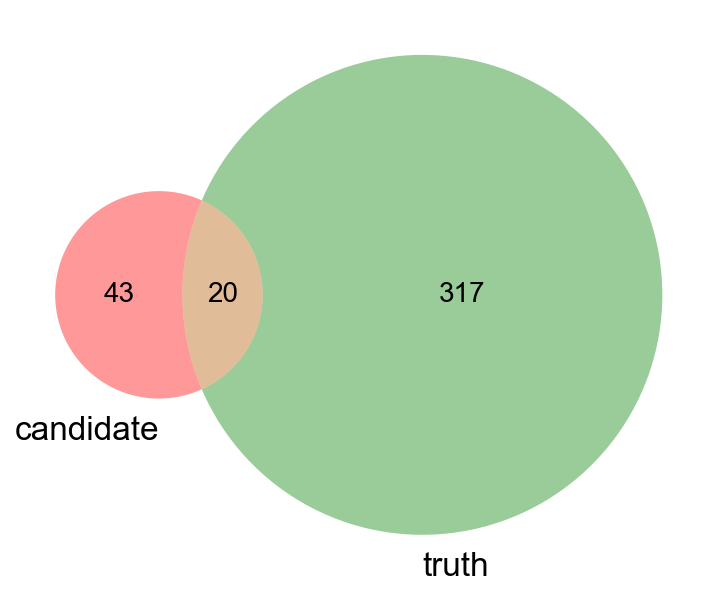

In [17]:
import find_unique_and_common_records
importlib.reload(find_unique_and_common_records)
from find_unique_and_common_records import find_unique_and_common_records_with_venn_diagram 

# TODO 
# plot this venn diagram for a variety of delta_meth_thresholds, 
# hopefully finding that our candidates "expand within" the truth set 

DF_IMPRINTED_CANDIDATES_UNIQUE, DF_IMPRINTED_TRUTH_UNIQUE, DF_IMPRINTED_COMMON = find_unique_and_common_records_with_venn_diagram(
    DF_IMPRINTED_CANDIDATES, 
    DF_IMPRINTED_TRUTH, 
    min_overlap=200, 
    labels=('candidate', 'truth')
)

In [18]:
# Almost all candidate loci that are found in the truth set are predicted to be methylated on maternal haplotype  
# "Previously reported ICRs that do not have gamete specific methylation are also included and labelled as having Somatic (S) methylation. "
Counter(DF_IMPRINTED_COMMON['Parental Origin of Methylation_2'].to_numpy())

Counter({'M': 19, 'S': 1})

In [19]:
# Some of these were validated in IGV: 
DF_IMPRINTED_COMMON

chrom,start,end,NA12877_num_cpgs,NA12877_num_valid_cpgs,NA12877_num_valid_cpgs_pat,NA12877_num_valid_cpgs_mat,NA12877_count,NA12877_model,NA12878_num_cpgs,NA12878_num_valid_cpgs,NA12878_num_valid_cpgs_pat,NA12878_num_valid_cpgs_mat,NA12878_count,NA12878_model,NA12887_num_cpgs,NA12887_num_valid_cpgs,NA12887_num_valid_cpgs_pat,NA12887_num_valid_cpgs_mat,NA12887_count,NA12887_model,NA12885_num_cpgs,NA12885_num_valid_cpgs,NA12885_num_valid_cpgs_pat,NA12885_num_valid_cpgs_mat,NA12885_count,NA12885_model,NA12883_num_cpgs,NA12883_num_valid_cpgs,NA12883_num_valid_cpgs_pat,NA12883_num_valid_cpgs_mat,NA12883_count,NA12883_model,NA12881_num_cpgs,NA12881_num_valid_cpgs,NA12881_num_valid_cpgs_pat,NA12881_num_valid_cpgs_mat,…,200102_num_valid_cpgs_mat,200102_count,200102_model,200103_num_cpgs,200103_num_valid_cpgs,200103_num_valid_cpgs_pat,200103_num_valid_cpgs_mat,200103_count,200103_model,200104_num_cpgs,200104_num_valid_cpgs,200104_num_valid_cpgs_pat,200104_num_valid_cpgs_mat,200104_count,200104_model,200105_num_cpgs,200105_num_valid_cpgs,200105_num_valid_cpgs_pat,200105_num_valid_cpgs_mat,200105_count,200105_model,200106_num_cpgs,200106_num_valid_cpgs,200106_num_valid_cpgs_pat,200106_num_valid_cpgs_mat,200106_count,200106_model,chrom_2,start_2,end_2,length_2,ID_2,Parental Origin of Methylation_2,Nearest Transcript_2,Distance to Nearest Transcript_2,overlap_len,locus_candidate
str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,…,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,str,i64,i64,i64,str,str,str,i64,i64,str
"""chr1""",68050000,68051000,47,47,47,47,-0.663043,-0.908319,47,47,47,47,-0.621553,-0.867681,47,47,47,47,0.617638,0.864426,47,47,47,47,-0.668915,-0.905,47,47,47,47,-0.661574,-0.860979,47,47,47,47,…,47,-0.608064,-0.826681,47,47,47,47,-0.651532,-0.900702,47,47,47,47,-0.644617,-0.840213,47,47,0,0,null,null,47,47,47,47,-0.657894,-0.895064,"""chr1""",68049858,68051097,1239,"""ICR_47^#""","""M""","""DIRAS3""",0,1000,"""chr1:68050000-68051000"""
"""chr4""",88697000,88698000,55,55,55,54,-0.734545,-0.915745,55,55,0,0,null,null,55,55,0,0,null,null,55,55,55,55,-0.679982,-0.876764,55,55,54,55,-0.668145,-0.855208,55,55,54,55,…,0,null,null,55,55,0,0,null,null,55,55,54,55,-0.636643,-0.845746,55,55,55,55,-0.6102,-0.8428,55,55,54,55,-0.676157,-0.877924,"""chr4""",88697244,88698085,841,"""ICR_275^""","""M""","""HERC3|NAP1L5""",0,756,"""chr4:88697000-88698000"""
"""chr6""",144007000,144008000,52,52,52,52,-0.673096,-0.834077,52,52,52,52,-0.672019,-0.845192,52,52,52,52,-0.666962,-0.853058,52,52,52,52,-0.702904,-0.884923,52,52,0,0,null,null,52,52,0,0,…,52,-0.68875,-0.830923,52,52,52,52,-0.684269,-0.862308,52,52,52,52,-0.702654,-0.903846,52,52,52,52,-0.684769,-0.889635,52,52,52,52,-0.705231,-0.877827,"""chr6""",144006941,144008825,1884,"""ICR_404^#""","""M""","""PLAGL1|HYMAI""",0,1000,"""chr6:144007000-144008000"""
"""chr7""",23490000,23491000,50,50,50,50,-0.7096,-0.89306,50,50,50,50,-0.50678,-0.59502,50,50,0,0,null,null,50,50,50,50,-0.43398,-0.55448,50,50,50,0,null,null,50,50,0,0,…,50,-0.74956,-0.90628,50,50,0,0,null,null,50,50,50,50,-0.65906,-0.8715,50,50,50,50,-0.68948,-0.87214,50,50,47,15,-0.667972,-0.820579,"""chr7""",23490490,23491453,963,"""ICR_443^""","""M""","""RPS2P32""",0,510,"""chr7:23490000-23491000"""
"""chr7""",50782000,50783000,117,117,0,0,null,null,117,117,117,117,-0.754376,-0.904949,117,117,117,117,-0.741,-0.905248,117,117,117,117,-0.764453,-0.904274,117,117,0,0,null,null,117,117,0,0,…,117,-0.659145,-0.819111,117,117,117,117,-0.701513,-0.865402,117,117,117,117,-0.732462,-0.872282,117,117,117,117,-0.710453,-0.84953,117,117,0,117,null,null,"""chr7""",50781638,50783354,1716,"""ICR_454*^#""","""M""","""GRB10""",0,1000,"""chr7:50782000-50783000"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…

## Some CpG sites are falsely labeled as not allele-specific because of VCF misses real SNVs

In [20]:
# Many of these are false positives, according to IGV, resulting from allele-specific cpgs that we have failed to filter out: 
DF_IMPRINTED_CANDIDATES_UNIQUE

chrom,start,end,NA12877_num_cpgs,NA12877_num_valid_cpgs,NA12877_num_valid_cpgs_pat,NA12877_num_valid_cpgs_mat,NA12877_count,NA12877_model,NA12878_num_cpgs,NA12878_num_valid_cpgs,NA12878_num_valid_cpgs_pat,NA12878_num_valid_cpgs_mat,NA12878_count,NA12878_model,NA12887_num_cpgs,NA12887_num_valid_cpgs,NA12887_num_valid_cpgs_pat,NA12887_num_valid_cpgs_mat,NA12887_count,NA12887_model,NA12885_num_cpgs,NA12885_num_valid_cpgs,NA12885_num_valid_cpgs_pat,NA12885_num_valid_cpgs_mat,NA12885_count,NA12885_model,NA12883_num_cpgs,NA12883_num_valid_cpgs,NA12883_num_valid_cpgs_pat,NA12883_num_valid_cpgs_mat,NA12883_count,NA12883_model,NA12881_num_cpgs,NA12881_num_valid_cpgs,NA12881_num_valid_cpgs_pat,NA12881_num_valid_cpgs_mat,…,200101_num_cpgs,200101_num_valid_cpgs,200101_num_valid_cpgs_pat,200101_num_valid_cpgs_mat,200101_count,200101_model,200102_num_cpgs,200102_num_valid_cpgs,200102_num_valid_cpgs_pat,200102_num_valid_cpgs_mat,200102_count,200102_model,200103_num_cpgs,200103_num_valid_cpgs,200103_num_valid_cpgs_pat,200103_num_valid_cpgs_mat,200103_count,200103_model,200104_num_cpgs,200104_num_valid_cpgs,200104_num_valid_cpgs_pat,200104_num_valid_cpgs_mat,200104_count,200104_model,200105_num_cpgs,200105_num_valid_cpgs,200105_num_valid_cpgs_pat,200105_num_valid_cpgs_mat,200105_count,200105_model,200106_num_cpgs,200106_num_valid_cpgs,200106_num_valid_cpgs_pat,200106_num_valid_cpgs_mat,200106_count,200106_model,locus
str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,…,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,str
"""chr1""",146170000,146171000,6,6,1,1,-0.304,-0.411,6,6,1,1,-0.948,-0.893,6,6,0,0,null,null,6,6,1,1,-0.079,0.03,6,6,1,1,0.307,0.233,5,5,0,0,…,6,6,0,0,null,null,6,6,1,0,null,null,6,6,1,1,0.049,0.141,6,6,1,1,0.199,0.175,6,6,1,1,0.3,0.226,6,6,1,0,null,null,"""chr1:146170000-146171000"""
"""chr1""",164206000,164207000,1,1,1,1,0.009,-0.038,1,1,1,1,-0.768,-0.809,1,1,1,1,0.708,0.654,1,1,1,1,0.077,0.056,1,1,1,1,0.271,0.352,1,1,1,1,…,1,1,1,1,0.813,0.785,1,1,1,1,-0.1,-0.198,1,1,1,1,0.667,0.696,1,1,1,1,0.909,0.898,1,1,1,1,-0.074,0.0,1,1,1,1,0.9,0.9,"""chr1:164206000-164207000"""
"""chr1""",248649000,248650000,3,3,3,3,-0.123,-0.079333,6,6,1,1,0.929,0.917,5,5,5,0,null,null,5,5,5,3,-0.226933,-0.2954,6,6,6,0,null,null,6,6,6,0,…,3,3,3,3,0.108333,0.087333,5,5,0,5,null,null,3,3,3,3,0.098333,0.165667,6,6,0,6,null,null,6,6,0,0,null,null,6,6,0,0,null,null,"""chr1:248649000-248650000"""
"""chr2""",70833000,70834000,10,10,5,5,0.0838,0.0336,10,10,10,10,-0.004,-0.0022,10,10,10,10,0.0018,-0.0049,10,10,10,10,-0.0823,-0.0767,10,10,0,0,null,null,10,10,0,0,…,10,10,10,10,0.0195,-0.0262,10,10,10,10,0.0133,0.0115,10,10,10,10,-0.0617,-0.0324,10,10,10,10,-0.0625,0.0038,10,10,5,5,-0.065,-0.0278,10,10,0,0,null,null,"""chr2:70833000-70834000"""
"""chr3""",18826000,18827000,8,8,8,1,0.662875,0.73025,7,7,1,7,-0.794714,-0.905857,6,6,6,0,null,null,6,6,6,0,null,null,9,1,0,0,null,null,9,1,0,0,…,8,4,1,4,-0.65,-0.7745,9,6,1,6,-0.579,-0.666167,8,4,1,4,-0.7175,-0.8,8,5,1,5,-0.6824,-0.7794,8,4,1,4,-0.69625,-0.78325,8,5,1,5,-0.6172,-0.7614,"""chr3:18826000-18827000"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chr20""",25769000,25770000,2,2,2,2,-0.721,-0.7285,8,8,8,8,0.197375,0.06625,8,8,8,8,0.291,0.37875,5,5,5,5,-0.1118,-0.1694,2,2,2,2,0.849,0.901,3,3,3,3,…,6,6,6,6,-0.489167,-0.469,7,7,7,7,-0.248571,-0.062571,7,7,7,7,-0.117571,-0.013571,7,7,7,7,-0.218571,-0.027571,5,5,5,5,0.0018,0.0158,8,8,8,8,-0.262125,-0.218875,"""chr20:25769000-25770000"""
"""chr20""",58889000,58890000,112,112,112,112,-0.751438,-0.907348,112,112,111,112,-0.764279,-0.914177,112,112,112,111,-0.707769,-0.89307,112,112,112,111,-0.768732,-0.914695,112,112,112,112,-0.747804,-0.882366,112,112,112,112,…,112,112,0,0,n

### Case 1

In [21]:
# TODO 
# look at multiple samples (and then delete)

In [22]:
! bash list_variants.sh 200081 chr1:146170000-146171000

Variants from single-sample VCF:
chr1	146170429	C	G	0|1
chr1	146170823	G	A	1|0

Variants from single-sample VCF (read-phased):
chr1	146170429	C	G	1|0
chr1	146170823	G	A	0|1

Variants from joint-called VCF:
chr1	146170015	T	C	0/0
chr1	146170429	C	G	1|0
chr1	146170635	G	A	./.
chr1	146170803	A	T	0/0
chr1	146170823	G	A	0|1
chr1	146170875	T	C	0/0
chr1	146170985	C	T	./.

Variants from joint-called VCF (inheritance-phased):
(This is the vcf we use to label CpG sites as allele-specific or not.)
chr1	146170015	T	C	0|0
chr1	146170823	G	A	1|0
chr1	146170875	T	C	0|0


In [23]:
# TODO: remove 
DF_METH.filter(
    (pl.col('chrom') == 'chr1') & 
    (pl.col('start') > 146170980) & 
    (pl.col('start') < 146170990) 
)

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,cpg_is_within_50bp_of_mismatch_site,cpg_overlaps_at_least_one_snv,snv_genotypes,cpg_is_allele_specific
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,str,bool
"""chr1""",146170984,146170986,82,0.671,0.61,146170822,146172217,1.0,1,19,58,"""I""","""K""",0.0,0.948,0.059,0.952,false,false,""".""",false


### Case 2

In [24]:
## TODO: complete case 2

In [25]:
def f():
    bed_meth = f"{METH_READ_PHASED_DIR}/NA12878.dna-methylation.founder-phased.all_cpgs.bed"
    df_meth = read_tapestry(bed_meth)
    df_meth_free_from_allele_specific_cpgs = df_meth.filter(~pl.col('cpg_is_allele_specific'))

    # This is the first tile in DF_IMPRINTED_CANDIDATES_UNIQUE
    # IGV says that the last CpG site in this tile overlaps a het SNV, 
    # which contradicts what the last three cols say. 
    # Need to resolve this discrepancy
    # If this is because the SNV does not appear in the joint vcf, then we can tolerate that, but we'd like to now that this is a source of false positives, perhaps to be filtered out a later stage (e.g., via num_cpgs_in_tile > 1)
    return df_meth_free_from_allele_specific_cpgs.filter(
        (pl.col('chrom') == "chr1") & 
        (pl.col('start') > 146170000) & 
        (pl.col('end') < 146171000) 
    )    

f()

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs/NA12878.dna-methylation.founder-phased.all_cpgs.bed'

## False-positive imprinted loci in the truth set

In [ ]:
# None of these look real in IGV in any of the sample I looked at!!!
# WHY??? 
DF_IMPRINTED_TRUTH_UNIQUE

## [All Samples] Inspect consistency of methylation on pat and mat haplotypes at candidate imprinted loci across samples 

In [ ]:
# This cell takes 5mins to run:

In [ ]:
# import imprinting 
# importlib.reload(imprinting)
# from imprinting import compute_methylation_all_samples_at_given_loci

# from write_data import write_dataframe_to_bed

# DF_METH_IMPRINTED_ALL_SAMPLES = compute_methylation_all_samples_at_given_loci(DF_IMPRINTED_CANDIDATES, METH_READ_PHASED_DIR)
# write_dataframe_to_bed(DF_METH_IMPRINTED_ALL_SAMPLES, 'imprinted_meth_all_samples.bed', source=globals()["__vsc_ipynb_file__"])

In [ ]:
DF_METH_IMPRINTED_CANDIDATES = read_all_samples('imprinted_meth_all_samples.bed')
DF_METH_IMPRINTED_CANDIDATES

In [ ]:
from get_palladium_prefixes import get_prefixes_wrapper

def plot_mat_vs_pat_meth(df, mode): 
    df = df.sample(8)
    for locus in df.iter_rows(named=True):
        chrom, start, end = locus['chrom'], locus['start'], locus['end']
        coordinate = f"{chrom}:{start}-{end}"
        print(coordinate)
        meths_pat, meths_mat, sample_ids = [], [], []
        for prefix in get_prefixes_wrapper():
            try:
                meths_pat.append(locus[f'{prefix}_{mode}_based_meth_pat'])
                meths_mat.append(locus[f'{prefix}_{mode}_based_meth_mat'])
                sample_ids.append(prefix)
            except KeyError: 
                continue

        for meth_pat, meth_mat, sample_id in zip(meths_pat, meths_mat, sample_ids): 
            if meth_pat is not None and meth_mat is not None: 
                print(f"{meth_pat:.2f}", f"{meth_mat:.2f}", sample_id, coordinate)

        plt.figure(figsize=(5,5))
        plt.scatter(
            meths_pat, 
            meths_mat,
            s=150,          
            marker='o',     
            edgecolor='black', 
            linewidths=2,   
            facecolor='red', 
            alpha=0.6   
        )
        plt.title(coordinate)
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.2)
        plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.2)
        plt.xlabel(f'paternal {mode}-based methylation')
        plt.ylabel(f'maternal {mode}-based methylation')
        plt.show()
        
plot_mat_vs_pat_meth(DF_METH_IMPRINTED_CANDIDATES, mode='count')

In [ ]:
plot_mat_vs_pat_meth(DF_METH_IMPRINTED_CANDIDATES, mode='model')

In [ ]:
plot_mat_vs_pat_meth(
    DF_METH_IMPRINTED_CANDIDATES.join(DF_IMPRINTED_COMMON.select(['chrom', 'start', 'end']), on=['chrom', 'start', 'end'], how='inner'), 
    mode='count'
)